In [1]:
import numpy as np
import os

import tensorflow as tf

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import TimeDistributed, Dense, Conv2D, MaxPooling2D, Dense, Flatten, LSTM

# Load and preprocessing

In [2]:
class SequenceDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory: str, batch_size: int, img_size: tuple or list, sequence_length: int):
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_length = sequence_length
        self.classes = sorted(os.listdir(directory))
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for label in self.classes:
            class_path = os.path.join(self.directory, label)
            images = sorted(os.listdir(class_path))
            for i in range(0, len(images) - self.sequence_length + 1):
                sample = (label, images[i:i + self.sequence_length])
                samples.append(sample)
        return samples

    def __len__(self) -> int:
        return len(self.samples) // self.batch_size

    def __getitem__(self, item):
        batch_samples = self.samples[item * self.batch_size:(item + 1) * self.batch_size]
        X = np.zeros((self.batch_size, self.sequence_length, *self.img_size, 3), dtype="float32")
        y = np.zeros((self.batch_size,), dtype="float32")

        for i, (label, images) in enumerate(batch_samples):
            for j, img_name in enumerate(images):
                img_path = os.path.join(self.directory, label, img_name)
                img = load_img(img_path, target_size=self.img_size)
                X[i, j] = img_to_array(img) / 255.0  # Normalize to [0, 1]
            y[i] = self.classes.index(label)

        return X, y

In [3]:
directory = r"C:\Users\Bintang\Desktop\All"
batch_size = 8
img_size = (224, 224)
sequence_length = 10

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

data_gen = SequenceDataGenerator(directory, batch_size, img_size, sequence_length)


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Model

In [4]:
inputs = tf.keras.layers.Input(shape=(10, 224, 224, 3))
x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(inputs)
x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Flatten())(x)
lstm1 = LSTM(128, return_sequences=True, name='lstm1')(x)
lstm2 = LSTM(128, return_sequences=False, name='lstm2')(lstm1)
dense = Dense(128, activation='relu')(lstm2)
outputs = Dense(1)(dense)

In [5]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 224, 224, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 10, 224, 224, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 224, 224, 32)  9248     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 112, 112, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 112, 112, 64)  18496

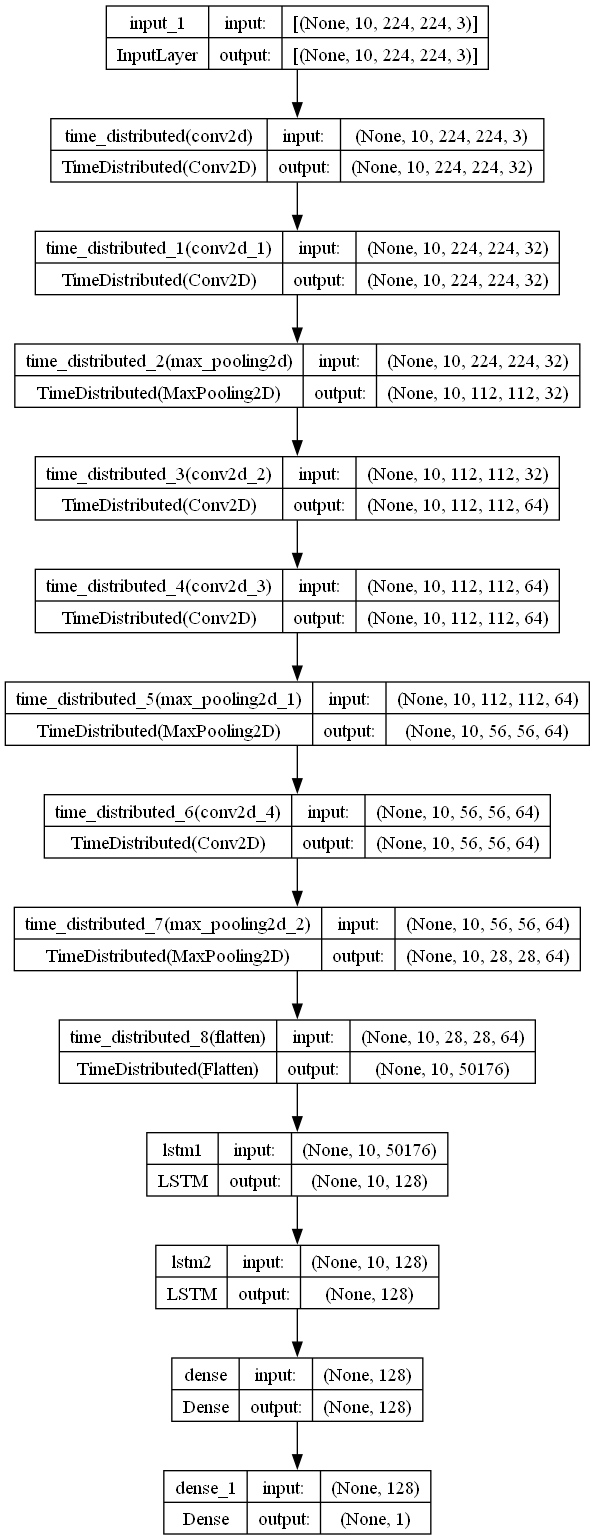

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [7]:
model.compile(
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=.001)
)

In [9]:
model.fit(data_gen, epochs=10)

Epoch 1/10
113/113 [==============================] - 111s 914ms/step - loss: 0.0000e+00 - accuracy: 0.0785
Epoch 2/10
113/113 [==============================] - 107s 941ms/step - loss: 0.0000e+00 - accuracy: 0.0785
Epoch 3/10
113/113 [==============================] - 107s 942ms/step - loss: 0.0000e+00 - accuracy: 0.0785
Epoch 4/10
113/113 [==============================] - 106s 936ms/step - loss: 0.0000e+00 - accuracy: 0.0896
Epoch 5/10
113/113 [==============================] - 106s 939ms/step - loss: 0.0000e+00 - accuracy: 0.1316
Epoch 6/10
113/113 [==============================] - 106s 934ms/step - loss: 0.0000e+00 - accuracy: 0.1316
Epoch 7/10
113/113 [==============================] - 106s 934ms/step - loss: 0.0000e+00 - accuracy: 0.1316
Epoch 8/10
113/113 [==============================] - 106s 934ms/step - loss: 0.0000e+00 - accuracy: 0.1316
Epoch 9/10
113/113 [==============================] - 106s 936ms/step - loss: 0.0000e+00 - accuracy: 0.1316
Epoch 10/10
113/113 [=======